In [25]:
import pandas as pd
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

df_bcn = pd.read_csv('Datasets/Final_cleaned_dataset/labled_features_bcn.csv', on_bad_lines='skip')
df_mad = pd.read_csv('Datasets/Final_cleaned_dataset/labled_features_mad.csv', on_bad_lines='skip')

In [37]:
from scipy import stats
import numpy as np

# Calculate z-scores for price
z_scores_bcn = np.abs(stats.zscore(df_bcn['price']))
z_scores_mad = np.abs(stats.zscore(df_mad['price']))

# Define a threshold
threshold = 3

# Remove outliers
df_bcn = df_bcn[(z_scores_bcn < threshold)]
df_mad = df_mad[(z_scores_mad < threshold)]

# Find and remove rows where 'neighbourhood' is "Sant Andreu" or "Gracias" and 'distance to city center' is less than 1 km
df_bcn = df_bcn[~((df_bcn['neighbourhood_group_cleansed'] == 'Sant Andreu') & (df_bcn['distance_from_city_center'] == '<1 km'))]
df_bcn = df_bcn[~((df_bcn['neighbourhood_group_cleansed'] == 'Gràcia') & (df_bcn['distance_from_city_center'] == '<1 km'))]

# Normalize 'price' and 'distance_from_city_center'
scaler = StandardScaler()
df_bcn[['price_normalized', 'distance_from_city_center_normalized']] = scaler.fit_transform(df_bcn[['price', 'distance_from_city_center']])
df_mad[['price_normalized', 'distance_from_city_center_normalized']] = scaler.fit_transform(df_mad[['price', 'distance_from_city_center']])
df_bcn[numerical_columns_bcn] = scaler.fit_transform(df_bcn[numerical_columns_bcn])

# For Madrid
df_mad[numerical_columns_mad] = scaler.fit_transform(df_mad[numerical_columns_mad])


/var/folders/l8/nzfg4l2524n0y13740c8fkm40000gn/T/ipykernel_2017/2027555862.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mad[['price_normalized', 'distance_from_city_center_normalized']] = scaler.fit_transform(df_mad[['price', 'distance_from_city_center']])
/var/folders/l8/nzfg4l2524n0y13740c8fkm40000gn/T/ipykernel_2017/2027555862.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mad[['price_normalized', 'distance_from_city_center_normalized']] = scaler.fit_transform(df_mad[['price', 'distan

In [28]:
df_bcn['host_is_superhost'] = df_bcn['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0) 
df_mad['host_is_superhost'] = df_mad['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)

### Update Feature and Target Variables

In [39]:
# Features for clustering and regression
X_bcn = df_bcn[['distance_from_city_center', 'host_is_superhost', 'kitchen', 'patio or balcony',
                'elevator', 'air conditioning', 'room_type_encoded', 'bedrooms_encoded',
                'number_of_reviews', 'review_scores_rating']]
y_bcn = df_bcn['price_normalized']

X_mad = df_mad[['distance_from_city_center', 'host_is_superhost', 'kitchen', 'patio or balcony',
                'elevator', 'air conditioning', 'room_type_encoded', 'bedrooms_encoded',
                'number_of_reviews', 'review_scores_rating']]
y_mad = df_mad['price_normalized']

# Standardize the data before clustering
scaler = StandardScaler()
X_bcn_scaled = scaler.fit_transform(X_bcn)
X_mad_scaled = scaler.fit_transform(X_mad)

# Apply DBSCAN for clustering
############COMENT NEEDED
dbscan_bcn = DBSCAN(eps=0.5, min_samples=5)
clusters_bcn = dbscan_bcn.fit_predict(X_bcn_scaled)

dbscan_mad = DBSCAN(eps=0.5, min_samples=5)
clusters_mad = dbscan_mad.fit_predict(X_mad_scaled)

# Add the cluster labels to the original datasets using .loc
X_bcn = X_bcn.copy()  # Ensure you're working with a copy of the DataFrame
X_bcn.loc[:, 'cluster'] = clusters_bcn

X_mad = X_mad.copy()  # Ensure you're working with a copy of the DataFrame
X_mad.loc[:, 'cluster'] = clusters_mad



In [40]:
# Split the data into training and testing sets
X_bcn_train, X_bcn_test, y_bcn_train, y_bcn_test = train_test_split(X_bcn, y_bcn, test_size=0.3, random_state=42)
X_mad_train, X_mad_test, y_mad_train, y_mad_test = train_test_split(X_mad, y_mad, test_size=0.3, random_state=42)


In [41]:
# Fit the linear regression model for Barcelona
model_bcn = LinearRegression()
model_bcn.fit(X_bcn_train, y_bcn_train)

# Fit the linear regression model for Madrid
model_mad = LinearRegression()
model_mad.fit(X_mad_train, y_mad_train)

# Predictions
y_bcn_pred = model_bcn.predict(X_bcn_test)
y_mad_pred = model_mad.predict(X_mad_test)

# Evaluate the model
mse_bcn = mean_squared_error(y_bcn_test, y_bcn_pred)
mse_mad = mean_squared_error(y_mad_test, y_mad_pred)

print(f'MSE Barcelona: {mse_bcn}')
print(f'MSE Madrid: {mse_mad}')

MSE Barcelona: 0.7516886565629065
MSE Madrid: 0.6629968406403681


In [43]:
from sklearn.metrics import r2_score

# Calculate R^2 for the Barcelona model
r2_bcn = r2_score(y_bcn_test, y_bcn_pred)
print(f'R^2 for Barcelona model: {r2_bcn}')

# Calculate R^2 for the Madrid model
r2_mad = r2_score(y_mad_test, y_mad_pred)
print(f'R^2 for Madrid model: {r2_mad}')



R^2 for Barcelona model: 0.257929287644711
R^2 for Madrid model: 0.32990719797882395


In [ ]:
# Barcelona Coefficients
coef_bcn = model_bcn.coef_
intercept_bcn = model_bcn.intercept_

print("Barcelona Model Coefficients:")
for feature, coef in zip(X_bcn.columns, coef_bcn):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept: {intercept_bcn:.2f}")

# Madrid Coefficients
coef_mad = model_mad.coef_
intercept_mad = model_mad.intercept_

print("\nMadrid Model Coefficients:")
for feature, coef in zip(X_mad.columns, coef_mad):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept: {intercept_mad:.2f}")

### Visualizing feature importances 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluation for Barcelona
mae_rf_bcn = mean_absolute_error(y_test_bcn, y_pred_rf_bcn)
mse_rf_bcn = mean_squared_error(y_test_bcn, y_pred_rf_bcn)
rmse_rf_bcn = np.sqrt(mse_rf_bcn)
r2_rf_bcn = r2_score(y_test_bcn, y_pred_rf_bcn)

print("Random Forest - Barcelona:")
print(f"MAE: {mae_rf_bcn:.2f}")
print(f"MSE: {mse_rf_bcn:.2f}")
print(f"RMSE: {rmse_rf_bcn:.2f}")
print(f"R²: {r2_rf_bcn:.2f}")

# Evaluation for Madrid
mae_rf_mad = mean_absolute_error(y_test_mad, y_pred_rf_mad)
mse_rf_mad = mean_squared_error(y_test_mad, y_pred_rf_mad)
rmse_rf_mad = np.sqrt(mse_rf_mad)
r2_rf_mad = r2_score(y_test_mad, y_pred_rf_mad)

print("\nRandom Forest - Madrid:")
print(f"MAE: {mae_rf_mad:.2f}")
print(f"MSE: {mse_rf_mad:.2f}")
print(f"RMSE: {rmse_rf_mad:.2f}")
print(f"R²: {r2_rf_mad:.2f}")


Random Forest - Barcelona:
MAE: 51.45
MSE: 9911.15
RMSE: 99.55
R²: 0.59

Random Forest - Madrid:
MAE: 28.47
MSE: 3036.37
RMSE: 55.10
R²: 0.61


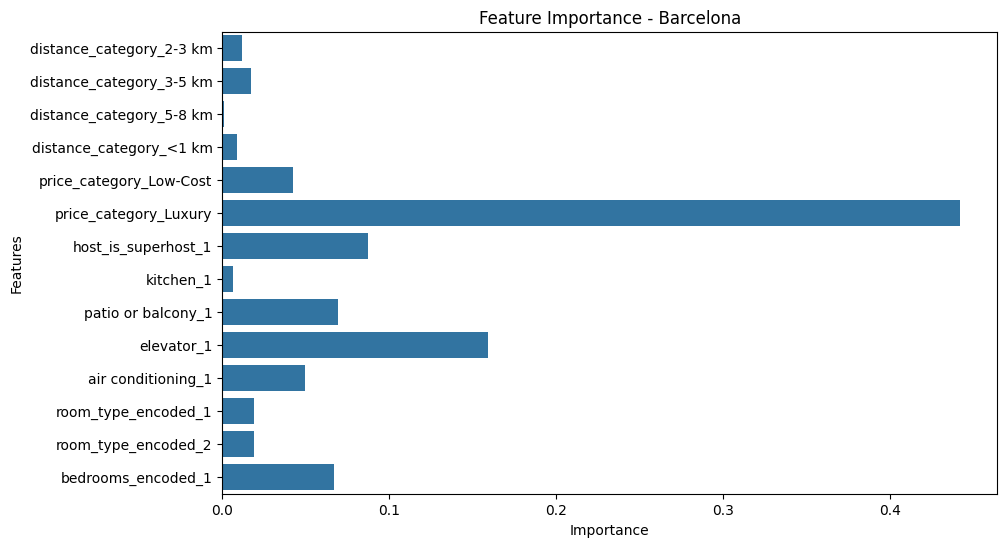

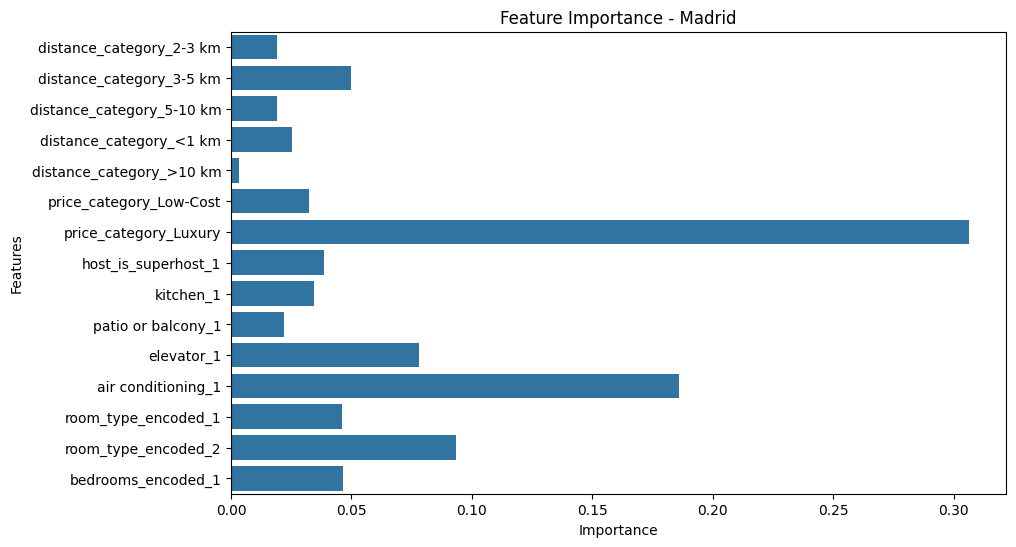

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Barcelona Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_model_bcn.feature_importances_, y=X_train_bcn.columns)
plt.title('Feature Importance - Barcelona')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Madrid Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_model_mad.feature_importances_, y=X_train_mad.columns)
plt.title('Feature Importance - Madrid')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
